In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

In [284]:
file_path = "../data/Red Bull Case Study Data.xlsx"

df = pd.read_excel(file_path, engine="openpyxl")

**Preprocessing**

Repeat steps from EDA

In [285]:
df["H4 Prd Variant"] = df["H4 Prd Variant"].replace(
    "Red Bull Watermlon Edition",
    "Red Bull Watermelon Edition"
)
df = df[df["Calendar Day"].dt.year >= 2018]

customer_cols = ["Customer A", "Customer B", "Customer C"]
df["Customer Total"] = df[customer_cols].sum(axis=1, skipna=True)

# If ALL customers are NaN → set total to NaN
all_nan_mask = df[customer_cols].isna().all(axis=1)
df.loc[all_nan_mask, "Customer Total"] = pd.NA

df["product_id"] = (
    df["H4 Prd Variant"] + " | "
    + df["H5 Prd Filling size"] + " | "
    + df["H7 Prd Pckg Unit"]
)
df=df.drop(columns=['H4 Prd Variant','H5 Prd Filling size','H7 Prd Pckg Unit'])

df = df.melt(
    id_vars=["Calendar Day", "product_id"],
    value_vars=["Customer A", "Customer B", "Customer C","Customer Total"],
    var_name="customer",
    value_name="demand"
)

df = df.drop_duplicates(
    subset=["Calendar Day", "product_id", "customer"],
    keep="first"
)


Exclude Products Red Bull Watermelon Edition | 355ml/12oz | Single and Red Bull Yellow Edition | 250ml/8.4oz | Single

In [286]:
products_to_drop = [
    "Red Bull Watermelon Edition | 355ml/12oz | Single",
    "Red Bull Yellow Edition | 250ml/8.4oz | Single",
]

df = df[~df["product_id"].isin(products_to_drop)]

Aggregate Weekly

In [287]:
df_weekly = (
    df
    .set_index("Calendar Day")
    .groupby(["product_id", "customer"])
    .resample("W")["demand"]
    .sum(min_count=1) 
    .reset_index()
)
df_weekly.head()

,product_id,customer,Calendar Day,demand
0,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-07,13254.0
1,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-14,9343.0
2,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-21,3586.0
3,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-01-28,36088.0
4,Red Bull Blue Edition | 250ml/8.4oz | Single,Customer A,2018-02-04,177.0


Add Payday indicator

In [ ]:
def add_payday_indicator_simple(df, date_col="Calendar Day"):
    """
    Adds a 'payday' column for weekly data.
    A week is marked as payday if its week-ending date falls between the 3rd and 8th of the month.
    
    Assumes df[date_col] is the week-ending date.
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Payday week if day of month is between 3 and 9
    df["payday"] = df[date_col].dt.day.between(3, 9).astype(int)
    
    return df

df_weekly = add_payday_indicator_simple(df_weekly, date_col="Calendar Day")

**Model**

In [315]:
def fit_dynamic_regression(
    df,
    train_period,
    val_period,
    product_id,
    customer="Customer Total",
    fourier_terms=None,
    trend_order=1,
    arma_order=(0, 0),
    d=0,  # <-- add differencing order here (0 or 1 typically)
    payday_indicator=True,
    y_transform=None,   # None, "log", "sqrt"
    ci_level=0.80,      # 80% CI by default
):
    """
    Fit dynamic regression (exog + ARIMA errors via SARIMAX), forecast validation,
    and compute coverage + RMSE metrics.

    Returns:
      - train/val dfs
      - X_train/X_val (including Calendar Day & week_number)
      - fitted model
      - forecast mean + 80% CI
      - coverage and RMSE metrics
    """

    # --- 0) Build modeling frame ---
    cols = ["Calendar Day", "demand"]
    if payday_indicator:
        cols.append("payday")  # must exist in df if payday_indicator=True

    df_model = df.loc[
        (df["product_id"] == product_id) &
        (df["customer"] == customer),
        cols
    ].copy()

    df_model.sort_values("Calendar Day", inplace=True)
    df_model.reset_index(drop=True, inplace=True)

    df_model["week_number"] = df_model["Calendar Day"].dt.isocalendar().week.astype(int)

    # Transform y for modeling if requested
    if y_transform == "log":
        # guard against non-positive
        if (df_model["demand"] <= 0).any():
            raise ValueError("y_transform='log' requires demand > 0 for all observations.")
        df_model["y_model"] = np.log(df_model["demand"])
    elif y_transform == "sqrt":
        if (df_model["demand"] < 0).any():
            raise ValueError("y_transform='sqrt' requires demand >= 0 for all observations.")
        df_model["y_model"] = np.sqrt(df_model["demand"])
    else:
        df_model["y_model"] = df_model["demand"].astype(float)

    # --- 1) Train/val split ---
    train_mask = (df_model["Calendar Day"] >= train_period[0]) & (df_model["Calendar Day"] <= train_period[1])
    val_mask   = (df_model["Calendar Day"] >= val_period[0])   & (df_model["Calendar Day"] <= val_period[1])

    train_df = df_model.loc[train_mask].copy()
    val_df   = df_model.loc[val_mask].copy()

    # Set Date index for clean alignment
    train_df = train_df.set_index("Calendar Day")
    val_df   = val_df.set_index("Calendar Day")

    y_train = train_df["y_model"]
    y_val_actual = val_df["demand"]  # evaluate on original scale

    # --- 2) Build X matrices (keep Calendar Day implicit via index) ---
    X_train = pd.DataFrame(index=train_df.index)
    X_val   = pd.DataFrame(index=val_df.index)

    X_train["week_number"] = train_df["week_number"].astype(int)
    X_val["week_number"]   = val_df["week_number"].astype(int)

    if payday_indicator:
        X_train["payday"] = train_df["payday"].astype(float)
        X_val["payday"]   = val_df["payday"].astype(float)

    # Trend terms
    t0 = np.arange(len(train_df), dtype=float)
    t1 = np.arange(len(train_df), len(train_df) + len(val_df), dtype=float)

    for i in range(1, trend_order + 1):
        X_train[f"trend_{i}"] = t0 ** i
        X_val[f"trend_{i}"]   = t1 ** i

    # Fourier seasonality using week_number
    if fourier_terms is not None and fourier_terms > 0:
        period = 52.0
        for k in range(1, fourier_terms + 1):
            X_train[f"sin_{k}"] = np.sin(2 * np.pi * k * X_train["week_number"] / period)
            X_train[f"cos_{k}"] = np.cos(2 * np.pi * k * X_train["week_number"] / period)
            X_val[f"sin_{k}"]   = np.sin(2 * np.pi * k * X_val["week_number"] / period)
            X_val[f"cos_{k}"]   = np.cos(2 * np.pi * k * X_val["week_number"] / period)

    # Exog passed to SARIMAX: drop week_number if you don't want it directly (you currently do)
    exog_cols = [c for c in X_train.columns if c != "week_number"]
    X_train_exog = X_train[exog_cols].astype(float)
    X_val_exog   = X_val[exog_cols].astype(float)

    # --- 3) Fit SARIMAX ---
    sarimax_model = SARIMAX(
        y_train,
        exog=X_train_exog,
        order=(arma_order[0], d, arma_order[1]),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_fit = sarimax_model.fit(disp=False)

    # --- 4) Forecast validation period (mean + CI on model scale) ---
    steps = len(val_df)
    fcst = sarimax_fit.get_forecast(steps=steps, exog=X_val_exog)

    fcst_mean_model = fcst.predicted_mean
    alpha = 1.0 - ci_level
    fcst_ci_model = fcst.conf_int(alpha=alpha)  # columns like 'lower y', 'upper y' (here likely 'lower demand' etc.)

    # Normalize CI column names safely
    lo_col = [c for c in fcst_ci_model.columns if "lower" in c.lower()][0]
    hi_col = [c for c in fcst_ci_model.columns if "upper" in c.lower()][0]

    # --- 5) Back-transform forecasts to original scale for evaluation ---
    def inv_transform(x: pd.Series) -> pd.Series:
        if y_transform == "log":
            return np.exp(x)
        elif y_transform == "sqrt":
            return np.square(x)
        else:
            return x

    fcst_mean = inv_transform(fcst_mean_model)
    fcst_lo   = inv_transform(fcst_ci_model[lo_col])
    fcst_hi   = inv_transform(fcst_ci_model[hi_col])

    # Align indices (should already match val_df index)
    fcst_mean = fcst_mean.reindex(val_df.index)
    fcst_lo   = fcst_lo.reindex(val_df.index)
    fcst_hi   = fcst_hi.reindex(val_df.index)

    # --- 6) Metrics ---
    inside_80 = (y_val_actual >= fcst_lo) & (y_val_actual <= fcst_hi)
    coverage_80 = float(inside_80.mean())

    rmse = float(np.sqrt(np.mean((fcst_mean - y_val_actual) ** 2)))
    actual_mean = float(y_val_actual.mean())
    rmse_rel_mean = float(rmse / actual_mean) if actual_mean != 0 else np.nan

    # Residuals on training (model scale)
    train_pred = sarimax_fit.get_prediction(start=y_train.index[0], end=y_train.index[-1]).predicted_mean
    residuals_model = y_train - train_pred

    return {
        "model": sarimax_fit,
        "train_df": train_df,
        "val_df": val_df,
        "X_train": X_train,
        "X_val": X_val,
        "y_train": y_train,
        "y_val": y_val_actual,
        "model_fit": sarimax_fit,
        "customer": customer,
        "product_id": product_id,

        "train_pred_model": train_pred,
        "residuals_model": residuals_model,

        "forecast_mean": fcst_mean,
        "forecast_ci": pd.DataFrame({"lower": fcst_lo, "upper": fcst_hi}, index=val_df.index),

        "metrics": {
            "coverage_80": coverage_80,
            "rmse": rmse,
            "rmse_rel_mean": rmse_rel_mean,
        }
    }


Plot Model on Train and Validation

In [ ]:
def plot_sarimax_fit_forecast(sarimax_fit, y_train, y_val, customer, product_id, X_train=None, X_val=None,alpha=0.2):
    """
    Plots SARIMAX in-sample fit and out-of-sample forecast.
    
    sarimax_fit: fitted SARIMAX model
    y_train: pandas Series, training endogenous
    y_val: pandas Series, validation endogenous
    X_train: pandas DataFrame of exogenous regressors for training (optional)
    X_val: pandas DataFrame of exogenous regressors for validation (optional)
    alpha: float, 1 - CI level (0.2 = 80% CI)
    """
    # --- 1. In-sample prediction on training data ---
    train_pred = sarimax_fit.get_prediction(start=0, end=len(y_train)-1)
    train_pred_mean = train_pred.predicted_mean
    train_pred_ci = train_pred.conf_int(alpha=alpha)

    # --- 2. Out-of-sample forecast for validation period ---
    forecast = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=alpha)

    # --- 3. Plot ---
    plt.figure(figsize=(14,6))

    # Training data actual and fit
    plt.plot(y_train.index, y_train, label="Train Actual", color="blue")
    plt.plot(y_train.index, train_pred_mean, label="Train Fit", color="orange")
    #plt.fill_between(y_train.index, train_pred_ci.iloc[:,0], train_pred_ci.iloc[:,1],
                    # color="orange", alpha=0.2)

    # Validation data actual and forecast
    plt.plot(y_val.index, y_val, label="Validation Actual", color="green")
    plt.plot(y_val.index, forecast_mean, label="Forecast", color="red")
    plt.fill_between(y_val.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1],
                     color="red", alpha=0.2)

    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.title(f"SARIMAX Fit and Forecast {customer} and {product_id}")
    plt.legend()
    plt.show()


In [342]:
def plot_sarimax_fit_forecast(
    sarimax_fit,
    y_train,
    y_val,
    customer,
    product_id,
    X_train=None,
    X_val=None,
    alpha=0.2,
    start_date=None,   # NEW ARGUMENT
):
    """
    Plots SARIMAX in-sample fit and out-of-sample forecast.

    start_date: optional datetime or string. Only dates >= start_date are plotted.
    """

    import pandas as pd
    import matplotlib.pyplot as plt

    # --- 1. In-sample prediction ---
    train_pred = sarimax_fit.get_prediction(start=0, end=len(y_train)-1)
    train_pred_mean = train_pred.predicted_mean
    train_pred_ci = train_pred.conf_int(alpha=alpha)

    # --- 2. Out-of-sample forecast ---
    forecast = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int(alpha=alpha)

    # --- 3. Apply start_date filter if provided ---
    if start_date is not None:

        start_date = pd.to_datetime(start_date)

        y_train_plot = y_train[y_train.index >= start_date]
        train_pred_mean_plot = train_pred_mean[train_pred_mean.index >= start_date]

        y_val_plot = y_val[y_val.index >= start_date]
        forecast_mean_plot = forecast_mean[forecast_mean.index >= start_date]
        forecast_ci_plot = forecast_ci[forecast_ci.index >= start_date]

    else:

        y_train_plot = y_train
        train_pred_mean_plot = train_pred_mean

        y_val_plot = y_val
        forecast_mean_plot = forecast_mean
        forecast_ci_plot = forecast_ci

    # --- 4. Plot ---
    plt.figure(figsize=(14,6))

    plt.plot(y_train_plot.index, y_train_plot, label="Train Actual", color="blue")
    plt.plot(train_pred_mean_plot.index, train_pred_mean_plot, label="Train Fit", color="orange")

    plt.plot(y_val_plot.index, y_val_plot, label="Test Actual", color="green")
    plt.plot(forecast_mean_plot.index, forecast_mean_plot, label="Forecast", color="red")

    plt.fill_between(
        forecast_ci_plot.index,
        forecast_ci_plot.iloc[:,0],
        forecast_ci_plot.iloc[:,1],
        color="red",
        alpha=0.2
    )

    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.title(f"SARIMAX Fit and Forecast {customer} and {product_id}")
    plt.legend()
    plt.show()


In [308]:
df_weekly['product_id'].unique()

<StringArray>
[      'Red Bull Blue Edition | 250ml/8.4oz | Single',
        'Red Bull Energy Drink | 250ml/8.4oz | 4Pack',
       'Red Bull Energy Drink | 250ml/8.4oz | Single',
        'Red Bull Energy Drink | 355ml/12oz | Single',
 'Red Bull Watermelon Edition | 250ml/8.4oz | Single']
Length: 5, dtype: str

/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


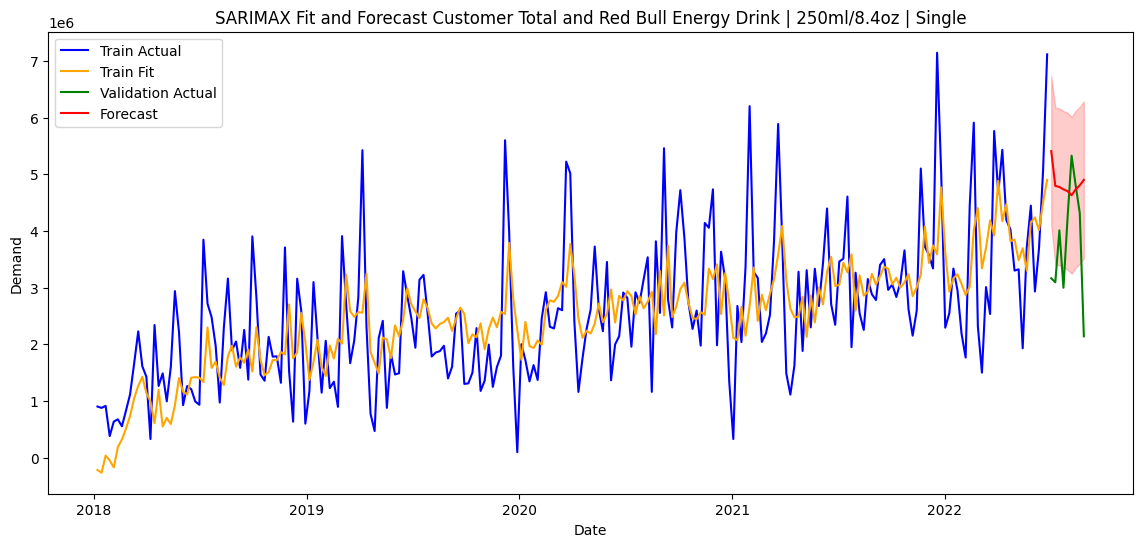

In [322]:
result = fit_dynamic_regression(
    df=df_weekly,                              # your full dataframe
    train_period=("2018-01-01", "2022-06-30"),
    val_period=("2022-07-01", "2022-08-31"),
    product_id="Red Bull Energy Drink | 250ml/8.4oz | Single",
    customer="Customer Total",

    fourier_terms=4,                    # seasonality flexibility
    trend_order=3,                      # polynomial trend
    arma_order=(1, 1),                  # ARMA(p,q)
    d=0,                                # differencing
    payday_indicator=True,

    y_transform=None,                   # or "log"
    ci_level=0.80                       # 80% CI
)

# Plot
plot_sarimax_fit_forecast(
    sarimax_fit=result["model_fit"], 
    y_train=result["y_train"], 
    y_val=result["y_val"],
    product_id=result["product_id"],
    customer=result["customer"], 
    X_train=result["X_train"].drop(columns=["week_number"]).astype(float), 
    X_val=result["X_val"].drop(columns=["week_number"]).astype(float)
)

Grid Search over hyperparameters

In [346]:
import pandas as pd
import numpy as np

def evaluate_model_backtests(
    df,
    product_id,
    customer,
    backtest_origins,
    val_weeks,
    params,
    target_coverage=0.80,
    y_transform=None,
):
    """
    Evaluate one model spec across multiple rolling backtests.

    Returns dict with averaged metrics.
    """

    coverages = []
    widths = []
    rmses_rel = []

    for origin in backtest_origins:

        train_period = (
            df["Calendar Day"].min(),
            pd.to_datetime(origin)
        )

        val_start = pd.to_datetime(origin) + pd.Timedelta(weeks=1)
        val_end = val_start + pd.Timedelta(weeks=val_weeks-1)

        val_period = (val_start, val_end)

        try:
            res = fit_dynamic_regression(
                df=df,
                train_period=train_period,
                val_period=val_period,
                product_id=product_id,
                customer=customer,
                fourier_terms=params["fourier_terms"],
                trend_order=params["trend_order"],
                arma_order=params["arma_order"],
                d=params["d"],
                payday_indicator=params["payday_indicator"],
                y_transform=y_transform,
                ci_level=target_coverage,
            )

            coverage = res["metrics"]["coverage_80"]
            rmse_rel = res["metrics"]["rmse_rel_mean"]

            ci = res["forecast_ci"]
            avg_width = (ci["upper"] - ci["lower"]).mean()

            coverages.append(coverage)
            widths.append(avg_width)
            rmses_rel.append(rmse_rel)

        except Exception:
            return None

    mean_coverage = np.mean(coverages)
    mean_width = np.mean(widths)
    mean_rmse_rel = np.mean(rmses_rel)

    return {
        "coverage": mean_coverage,
        "cov_dev": abs(mean_coverage - target_coverage),
        "avg_ci_width": mean_width,
        "rmse_rel_mean": mean_rmse_rel
    }

import itertools

def grid_search_backtests(
    df,
    product_id,
    customer,
    backtest_origins,
    val_weeks,
    grid,
    target_coverage=0.80,
):
    results = []

    keys = list(grid.keys())
    combos = list(itertools.product(*grid.values()))

    for values in combos:

        params = dict(zip(keys, values))

        metrics = evaluate_model_backtests(
            df=df,
            product_id=product_id,
            customer=customer,
            backtest_origins=backtest_origins,
            val_weeks=val_weeks,
            params=params,
            target_coverage=target_coverage
        )

        if metrics is None:
            continue

        results.append({
            **params,
            **metrics
        })

        print(params, metrics)

    results_df = pd.DataFrame(results)

    results_df = results_df.sort_values(
        by=["cov_dev", "avg_ci_width", "rmse_rel_mean"],
        ascending=[True, True, True]
    ).reset_index(drop=True)

    best_params = results_df.iloc[0][keys].to_dict()

    return best_params, results_df

grid = {
    "fourier_terms": [2,4,6],
    "trend_order": [1,2,3],
    "arma_order": [(0,0),(1,0),(0,1),(1,1)],
    "d": [0,1],
    "payday_indicator": [False,True]
}

backtest_origins = [
    "2021-06-30",
    "2021-12-31",
    "2022-04-30"
]

best_params, results_df = grid_search_backtests(
    df=df_weekly,
    product_id="Red Bull Energy Drink | 250ml/8.4oz | Single",
    customer="Customer Total",
    backtest_origins=backtest_origins,
    val_weeks=12,
    grid=grid,
    target_coverage=0.80
)

print(best_params)



/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(45577873.254241966), 'rmse_rel_mean': np.float64(0.49973364490304517)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(45226665.53081434), 'rmse_rel_mean': np.float64(0.48569146081171377)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115840705.9698546), 'rmse_rel_mean': np.float64(0.488530237794401)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115768687.64515984), 'rmse_rel_mean': np.float64(0.49015213130576596)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3177179.3404002464), 'rmse_rel_mean': np.float64(0.5001423294169388)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3158764.1471412643), 'rmse_rel_mean': np.float64(0.487163907433437)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(6473068.728127837), 'rmse_rel_mean': np.float64(0.5316809954268992)}
{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(6458377.483005956), 'rmse_rel_mean': np.float64(0.5333187118899888)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3147068.877476275), 'rmse_rel_mean': np.float64(0.4997336448951369)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3126895.7616374525), 'rmse_rel_mean': np.float64(0.4856914608052317)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(3045380.79623308), 'rmse_rel_mean': np.float64(0.3745611296906272)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(3041223.249691075), 'rmse_rel_mean': np.float64(0.3762277820944359)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3194616.661620974), 'rmse_rel_mean': np.float64(0.5035516451578629)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3177124.1583903544), 'rmse_rel_mean': np.float64(0.4873235740466865)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(3016031.713324591), 'rmse_rel_mean': np.float64(0.3722627263163047)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(3023530.353669245), 'rmse_rel_mean': np.float64(0.3737914950552092)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(41537617.17905908), 'rmse_rel_mean': np.float64(0.36272613615624216)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(41488927.041235976), 'rmse_rel_mean': np.float64(0.36269746667621455)}
{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115838398.49936378), 'rmse_rel_mean': np.float64(0.5071827752280039)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115766370.15917532), 'rmse_rel_mean': np.float64(0.5090112213077731)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2900618.5502720308), 'rmse_rel_mean': np.float64(0.36533428300995713)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2898799.187076146), 'rmse_rel_mean': np.float64(0.3651056939065948)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(6472370.885857471), 'rmse_rel_mean': np.float64(0.5505305572667883)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(6457666.136394474), 'rmse_rel_mean': np.float64(0.5524354062171843)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2881614.788693298), 'rmse_rel_mean': np.float64(0.36272604150039967)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2881907.408617711), 'rmse_rel_mean': np.float64(0.3626973684878727)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(3139934.87144554), 'rmse_rel_mean': np.float64(0.3600084918911343)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(3050143.744285157), 'rmse_rel_mean': np.float64(0.3948628760567699)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2914729.879579536), 'rmse_rel_mean': np.float64(0.3634980400491354)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7575757575757575), 'cov_dev': np.float64(0.042424242424242586), 'avg_ci_width': np.float64(2912217.391871279), 'rmse_rel_mean': np.float64(0.363284569595041)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(3021729.9108377476), 'rmse_rel_mean': np.float64(0.3924453530851917)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(3040492.0248348024), 'rmse_rel_mean': np.float64(0.39680072862104315)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(39439625.62030275), 'rmse_rel_mean': np.float64(0.48401106779871245)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(39426448.92262339), 'rmse_rel_mean': np.float64(0.484490706355124)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115831242.97236383), 'rmse_rel_mean': np.float64(0.5531978402764712)}
{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115759528.5939753), 'rmse_rel_mean': np.float64(0.554481537370123)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.42424242424242425), 'cov_dev': np.float64(0.3757575757575758), 'avg_ci_width': np.float64(2755469.1504283794), 'rmse_rel_mean': np.float64(0.48455282761317214)}
{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2754918.780184597), 'rmse_rel_mean': np.float64(0.485116664505548)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(6469760.895993527), 'rmse_rel_mean': np.float64(0.6069787022497964)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(6455145.787104216), 'rmse_rel_mean': np.float64(0.6082451748946472)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.42424242424242425), 'cov_dev': np.float64(0.3757575757575758), 'avg_ci_width': np.float64(2765140.29263687), 'rmse_rel_mean': np.float64(0.4830598828716786)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2765008.6641901005), 'rmse_rel_mean': np.float64(0.4835598347556935)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3045339.931096791), 'rmse_rel_mean': np.float64(0.43194421728217297)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(3049297.9883166463), 'rmse_rel_mean': np.float64(0.43111248562244797)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.42424242424242425), 'cov_dev': np.float64(0.3757575757575758), 'avg_ci_width': np.float64(2771247.2793234102), 'rmse_rel_mean': np.float64(0.48319222479960094)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2770686.5682461024), 'rmse_rel_mean': np.float64(0.4837163844743073)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(2998045.044962534), 'rmse_rel_mean': np.float64(0.4300121576056637)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 2, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(2996331.0872758403), 'rmse_rel_mean': np.float64(0.4311977107366182)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(44894677.54798561), 'rmse_rel_mean': np.float64(0.48791250606804243)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(44522367.805835), 'rmse_rel_mean': np.float64(0.473557301111814)}
{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115313958.62652813), 'rmse_rel_mean': np.float64(0.45569150622850535)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115241619.23658283), 'rmse_rel_mean': np.float64(0.4572575555420249)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(3129647.164742509), 'rmse_rel_mean': np.float64(0.48692761572406673)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3109955.8315328914), 'rmse_rel_mean': np.float64(0.47383405736551176)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(6406856.570886187), 'rmse_rel_mean': np.float64(0.49041387606409986)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(6391913.623041063), 'rmse_rel_mean': np.float64(0.49205099561204274)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(3096716.2288674195), 'rmse_rel_mean': np.float64(0.487912506058859)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3075631.2330609798), 'rmse_rel_mean': np.float64(0.4735573011040766)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(3006670.1485774703), 'rmse_rel_mean': np.float64(0.35405136888601635)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(3002669.5326588987), 'rmse_rel_mean': np.float64(0.35602198931744583)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(3038458.4772404563), 'rmse_rel_mean': np.float64(0.468371154175181)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3122013.53751345), 'rmse_rel_mean': np.float64(0.4740504906655128)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(3115999.722692696), 'rmse_rel_mean': np.float64(0.3575261178962395)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(3091912.8143188604), 'rmse_rel_mean': np.float64(0.3588610590118552)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(40696865.771331675), 'rmse_rel_mean': np.float64(0.36125565548833355)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(40642430.76868815), 'rmse_rel_mean': np.float64(0.3609060979989021)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115311726.34257805), 'rmse_rel_mean': np.float64(0.47525995810067273)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115239372.40327896), 'rmse_rel_mean': np.float64(0.4770476906011769)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2841352.0203538537), 'rmse_rel_mean': np.float64(0.3620646281450573)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2839397.1033833004), 'rmse_rel_mean': np.float64(0.3610993667405691)}
{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(6406298.995601538), 'rmse_rel_mean': np.float64(0.5104305119295525)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8181818181818182), 'cov_dev': np.float64(0.018181818181818188), 'avg_ci_width': np.float64(6391340.679957636), 'rmse_rel_mean': np.float64(0.5123374943535755)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(2823255.4832777344), 'rmse_rel_mean': np.float64(0.3612555152360142)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2823511.486204326), 'rmse_rel_mean': np.float64(0.3609059512171644)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(3019064.9632299407), 'rmse_rel_mean': np.float64(0.3634469851758422)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(3015121.9665695536), 'rmse_rel_mean': np.float64(0.3660622382270506)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2847101.3648956376), 'rmse_rel_mean': np.float64(0.3614495004269149)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2844089.5183946653), 'rmse_rel_mean': np.float64(0.3610116278451096)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(3112658.1084664785), 'rmse_rel_mean': np.float64(0.37890438614448674)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(3183115.6749988757), 'rmse_rel_mean': np.float64(0.3708721173424235)}
{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(38645725.6436626), 'rmse_rel_mean': np.float64(0.4664429884252661)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(38630326.449756175), 'rmse_rel_mean': np.float64(0.4667960627221131)}
{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115305179.529705), 'rmse_rel_mean': np.float64(0.5263010986741313)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(115233130.62966359), 'rmse_rel_mean': np.float64(0.5272330239279753)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2699452.532461934), 'rmse_rel_mean': np.float64(0.46606314816581845)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(2698866.588161389), 'rmse_rel_mean': np.float64(0.46652443413001715)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7575757575757577), 'cov_dev': np.float64(0.042424242424242364), 'avg_ci_width': np.float64(6404310.99464165), 'rmse_rel_mean': np.float64(0.5713589548721291)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(6389424.368109827), 'rmse_rel_mean': np.float64(0.5723682107899822)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2710884.7018383783), 'rmse_rel_mean': np.float64(0.4653229871663937)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(2710778.61220962), 'rmse_rel_mean': np.float64(0.4657118261314441)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3014482.6875520945), 'rmse_rel_mean': np.float64(0.40259785738868265)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.5757575757575758), 'cov_dev': np.float64(0.22424242424242424), 'avg_ci_width': np.float64(3014350.3073369437), 'rmse_rel_mean': np.float64(0.4019595157092879)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2709293.3848392437), 'rmse_rel_mean': np.float64(0.4653806572062173)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(2708697.077690396), 'rmse_rel_mean': np.float64(0.46579538847272817)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(2980975.994971924), 'rmse_rel_mean': np.float64(0.3997194029680658)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 4, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(2986607.606191106), 'rmse_rel_mean': np.float64(0.40316969001026814)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(44036943.49137061), 'rmse_rel_mean': np.float64(0.4999479489143653)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(43653908.12581878), 'rmse_rel_mean': np.float64(0.4850999468910387)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114506617.9832742), 'rmse_rel_mean': np.float64(0.44517298613326356)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114433209.40283443), 'rmse_rel_mean': np.float64(0.4460924508640492)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(3066694.484110438), 'rmse_rel_mean': np.float64(0.49918853757331294)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3047145.5568303517), 'rmse_rel_mean': np.float64(0.48550117988344876)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(6268910.607512099), 'rmse_rel_mean': np.float64(0.4826949909542422)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.8484848484848485), 'cov_dev': np.float64(0.048484848484848464), 'avg_ci_width': np.float64(6253840.570946845), 'rmse_rel_mean': np.float64(0.4836312050849711)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.48484848484848486), 'cov_dev': np.float64(0.3151515151515152), 'avg_ci_width': np.float64(3046541.4727436327), 'rmse_rel_mean': np.float64(0.49994794890753375)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3024337.559919294), 'rmse_rel_mean': np.float64(0.48509994688568453)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2930942.1530867144), 'rmse_rel_mean': np.float64(0.3625402640187725)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(2927481.696896943), 'rmse_rel_mean': np.float64(0.3643257210059971)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.5151515151515151), 'cov_dev': np.float64(0.2848484848484849), 'avg_ci_width': np.float64(2982902.84329208), 'rmse_rel_mean': np.float64(0.47903970218174546)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(3059752.0221607625), 'rmse_rel_mean': np.float64(0.48599320968655046)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(2844830.9172087237), 'rmse_rel_mean': np.float64(0.36354941342673747)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 1, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6969696969696969), 'cov_dev': np.float64(0.10303030303030314), 'avg_ci_width': np.float64(2820567.5572075783), 'rmse_rel_mean': np.float64(0.3600871052200573)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(39768950.11410741), 'rmse_rel_mean': np.float64(0.3655379325476824)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(39711076.190193266), 'rmse_rel_mean': np.float64(0.36470379117094404)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114504874.7672293), 'rmse_rel_mean': np.float64(0.46143132332899545)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114431388.24955), 'rmse_rel_mean': np.float64(0.46262928051508406)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2773440.5337118707), 'rmse_rel_mean': np.float64(0.36506217076962594)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2771475.413966154), 'rmse_rel_mean': np.float64(0.3641561218008844)}
{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(6268315.686935789), 'rmse_rel_mean': np.float64(0.4992108556593095)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.787878787878788), 'cov_dev': np.float64(0.012121212121212088), 'avg_ci_width': np.float64(6253227.036458301), 'rmse_rel_mean': np.float64(0.5004818841774137)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2763891.8630890925), 'rmse_rel_mean': np.float64(0.36553773235359466)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2764090.521946565), 'rmse_rel_mean': np.float64(0.36470358528988145)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(2939190.2657342455), 'rmse_rel_mean': np.float64(0.3706168042929711)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2925021.129375251), 'rmse_rel_mean': np.float64(0.3539468216517427)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2778367.851889329), 'rmse_rel_mean': np.float64(0.36551435166960483)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(2775172.7977039465), 'rmse_rel_mean': np.float64(0.3646636176156191)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(2869249.0270797596), 'rmse_rel_mean': np.float64(0.3562863898915238)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(2845308.1558619463), 'rmse_rel_mean': np.float64(0.38268239758811246)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(37668417.132025756), 'rmse_rel_mean': np.float64(0.47837295073242253)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(37652052.41872444), 'rmse_rel_mean': np.float64(0.4783840926570086)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114499292.20708688), 'rmse_rel_mean': np.float64(0.5041386540536372)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.9090909090909091), 'cov_dev': np.float64(0.10909090909090902), 'avg_ci_width': np.float64(114426107.55146253), 'rmse_rel_mean': np.float64(0.5043180492504212)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2627644.7840572563), 'rmse_rel_mean': np.float64(0.47860298625537984)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2627106.4853232373), 'rmse_rel_mean': np.float64(0.47871003500411796)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(6266448.98178979), 'rmse_rel_mean': np.float64(0.551030064267702)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.7272727272727272), 'cov_dev': np.float64(0.07272727272727286), 'avg_ci_width': np.float64(6251438.063401203), 'rmse_rel_mean': np.float64(0.5511923405388343)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2644945.6300257086), 'rmse_rel_mean': np.float64(0.4778107522991783)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2644823.594781537), 'rmse_rel_mean': np.float64(0.47785436512338003)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(2934024.358937945), 'rmse_rel_mean': np.float64(0.395318245220558)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (0, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6363636363636364), 'cov_dev': np.float64(0.1636363636363637), 'avg_ci_width': np.float64(2929895.009983541), 'rmse_rel_mean': np.float64(0.39621921482053385)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': False} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2636678.6436677394), 'rmse_rel_mean': np.float64(0.4779153173794081)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 0, 'payday_indicator': True} {'coverage': np.float64(0.45454545454545453), 'cov_dev': np.float64(0.3454545454545455), 'avg_ci_width': np.float64(2636184.2995477472), 'rmse_rel_mean': np.float64(0.47797116645558707)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was prov

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': False} {'coverage': np.float64(0.6666666666666666), 'cov_dev': np.float64(0.13333333333333341), 'avg_ci_width': np.float64(2856292.358084543), 'rmse_rel_mean': np.float64(0.3889109015212238)}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency info

{'fourier_terms': 6, 'trend_order': 3, 'arma_order': (1, 1), 'd': 1, 'payday_indicator': True} {'coverage': np.float64(0.6060606060606061), 'cov_dev': np.float64(0.19393939393939397), 'avg_ci_width': np.float64(2822772.00289876), 'rmse_rel_mean': np.float64(0.3990014534536613)}
{'fourier_terms': 6, 'trend_order': 2, 'arma_order': (1, 0), 'd': 1, 'payday_indicator': True}


/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [347]:
best_params

{'fourier_terms': 6,
 'trend_order': 2,
 'arma_order': (1, 0),
 'd': 1,
 'payday_indicator': True}

/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/raine/.cache/pypoetry/virtualenvs/redbull-case-study-syfHuXXp-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


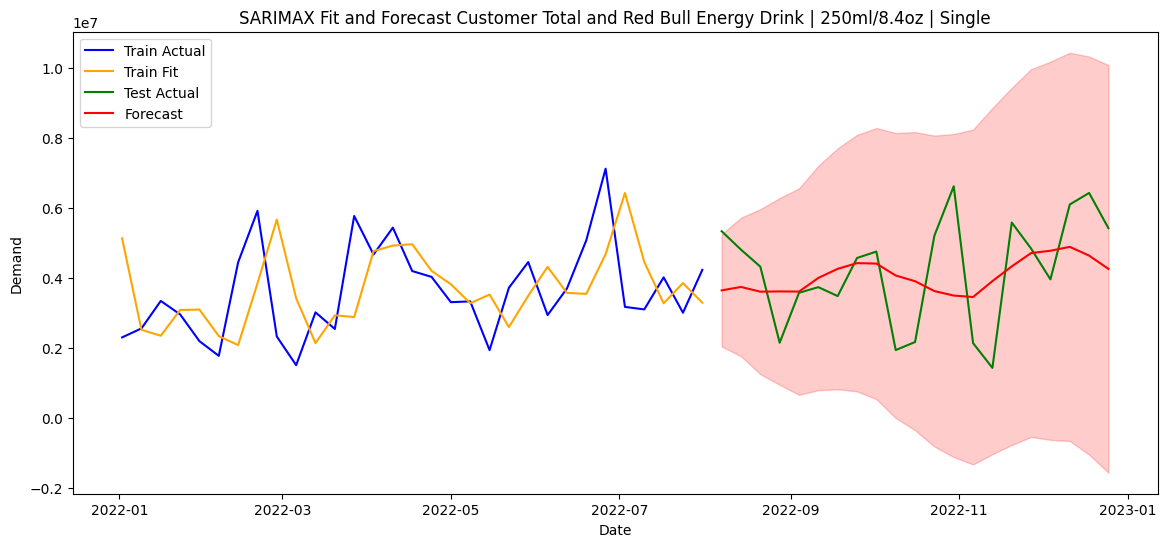

In [348]:
result = fit_dynamic_regression(
    df=df_weekly,                              # your full dataframe
    train_period=("2018-01-01", "2022-07-31"),
    val_period=("2022-08-01", "2022-12-31"),
    product_id="Red Bull Energy Drink | 250ml/8.4oz | Single",
    customer="Customer Total",

    **best_params,

    y_transform=None,                   # or "log"
    ci_level=0.80                       # 80% CI
)

# Plot
plot_sarimax_fit_forecast(
    sarimax_fit=result["model_fit"], 
    y_train=result["y_train"], 
    y_val=result["y_val"],
    product_id=result["product_id"],
    customer=result["customer"], 
    X_train=result["X_train"].drop(columns=["week_number"]).astype(float), 
    X_val=result["X_val"].drop(columns=["week_number"]).astype(float),
    start_date="2022-01-01",
    alpha=0.2
)